Họ và tên: Võ Hồng Quân


MSSV: 22134012


Lớp: 22134

In [1]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()

In [3]:

# SplitDataset class to load and split the data
class SplitDataset:
    def __init__(self, path='', train_test_split_size=[]):
        self.data = scipy.io.loadmat(path)
        self.inputs = self.data['X']
        self.targets = np.ravel(self.data['y'])
        self.train_test_split_size = train_test_split_size

        # Modify label 1-10 into 0-9
        self.targets[self.targets == 10] = 0

    def __call__(self):
        if self.train_test_split_size:
            train_size, test_size, valid_size = self.train_test_split_size
            self.X_new, self.X_test, self.y_new, self.y_test = train_test_split(
                self.inputs, self.targets, train_size=train_size, test_size=test_size)
            self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(
                self.X_new, self.y_new, test_size=valid_size / (train_size + valid_size))

        self.train = [self.X_train, self.y_train]
        self.test = [self.X_test, self.y_test]
        self.valid = [self.X_valid, self.y_valid]
        
        return self.train, self.test, self.valid

In [4]:

# Custom Dataset class
class GetDataset(Dataset):
    def __init__(self, transforms=None, dataset=None):
        super().__init__()
        self.transform = transforms
        self.inputs, self.targets = dataset

    def __getitem__(self, index):
        sample = self.inputs[index], self.targets[index]

        if self.transform:
            sample = self.transform(sample)

        return sample
        
    def __len__(self):
        return len(self.inputs)

In [5]:
# Transformation class to convert data to tensors
class Transform:
    def __call__(self, sample):
        inputs, targets = sample
        inputs = inputs.astype(np.float32).reshape(1, 20, 20)  # Reshape to (1, 20, 20)
        targets = torch.tensor(targets, dtype=torch.long)
        return torch.from_numpy(inputs), targets

In [6]:
# Load and split the dataset
train_array, test_array, valid_array = SplitDataset( path='ex7data.mat', train_test_split_size=[0.7, 0.2, 0.1]).__call__()
train_tensor = GetDataset(transforms=Transform(), dataset=train_array)
test_tensor = GetDataset(transforms=Transform(), dataset=test_array)
valid_tensor = GetDataset(transforms=Transform(), dataset=valid_array)

In [7]:

# DataLoaders
batch_size = 200
train_loader = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset=valid_tensor, batch_size=batch_size, shuffle=False)

In [8]:
# Updated ConvNet architecture
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),  # Output: [32, 18, 18]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # Output: [32, 9, 9]

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # Output: [64, 7, 7]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # Output: [64, 3, 3]

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),# Output: [128, 1, 1]
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 10)  # Output logits for 10 classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [9]:
# Initialize the model
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adagrad(params= model.parameters(), lr= 0.01)
scheduler = lr_scheduler.StepLR(optimizer= optimizer, step_size= 350, gamma= 0.1)

In [10]:
# Training Loop
num_epochs = 2000
loss_ = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)  # Outputs of shape [batch_size, 10]

        # print(targets.shape)
        # print(outputs.shape)
        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    loss_.append(avg_loss)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}") 


Epoch [100/2000], Loss: 0.0026
Epoch [200/2000], Loss: 0.0007
Epoch [300/2000], Loss: 0.0004
Epoch [400/2000], Loss: 0.0003
Epoch [500/2000], Loss: 0.0003
Epoch [600/2000], Loss: 0.0002
Epoch [700/2000], Loss: 0.0002
Epoch [800/2000], Loss: 0.0002
Epoch [900/2000], Loss: 0.0002
Epoch [1000/2000], Loss: 0.0002
Epoch [1100/2000], Loss: 0.0002
Epoch [1200/2000], Loss: 0.0002
Epoch [1300/2000], Loss: 0.0002
Epoch [1400/2000], Loss: 0.0002
Epoch [1500/2000], Loss: 0.0002
Epoch [1600/2000], Loss: 0.0002
Epoch [1700/2000], Loss: 0.0002
Epoch [1800/2000], Loss: 0.0002
Epoch [1900/2000], Loss: 0.0002
Epoch [2000/2000], Loss: 0.0002


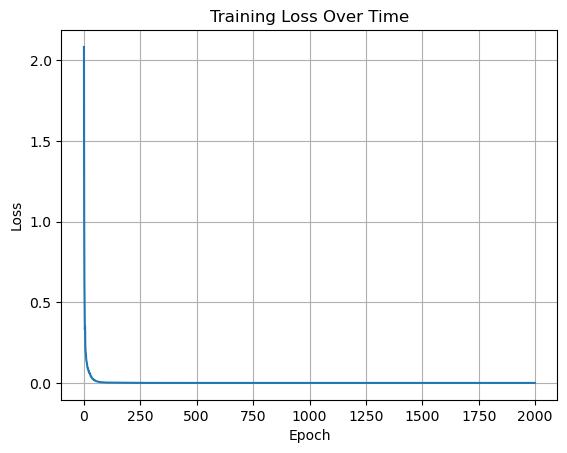

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [12]:
# Testing Loop
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(10)]
    n_class_samples = [0 for _ in range(10)]
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Outputs of shape [batch_size, 10]
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Overall Accuracy: {acc:.2f}%')

    for i in range(10):
        if n_class_samples[i] > 0:
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of class {classes[i]}: {acc:.4f}%')
        else:
            print(f'Accuracy of class {classes[i]}: N/A (no samples)')

Overall Accuracy: 97.00%
Accuracy of class 0: 97.9167%
Accuracy of class 1: 95.8333%
Accuracy of class 2: 99.0566%
Accuracy of class 3: 94.5455%
Accuracy of class 4: 99.0385%
Accuracy of class 5: 99.0000%
Accuracy of class 6: 97.1154%
Accuracy of class 7: 95.7447%
Accuracy of class 8: 96.9388%
Accuracy of class 9: 94.5652%
